In [68]:
import matplotlib.pyplot as plt
# opencv
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten

import os
import shutil
from sklearn.model_selection import train_test_split

### Splitting data because flow directory expects it in that manner

In [69]:
import os
print(os.getcwd())


c:\Users\Zehra\Desktop\CV\Classifiers\Weather_Pred


### Checking the datasets and paths

In [70]:
dew_img = cv2.imread(r'D:\DATA_FOR_CV\DATA\Weather_dataset\dew\2208.jpg')

type(dew_img)

numpy.ndarray

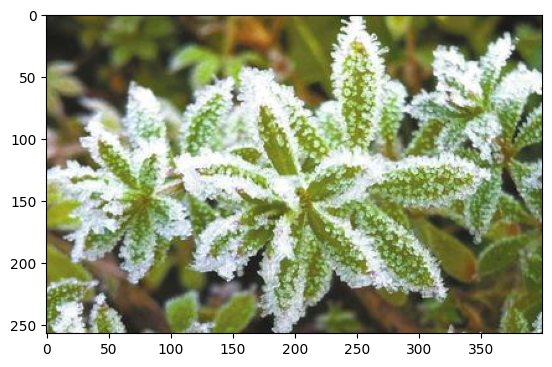

In [71]:
frost_img =cv2.cvtColor(cv2.imread(r'D:\DATA_FOR_CV\DATA\Weather_dataset\frost\3600.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(frost_img)

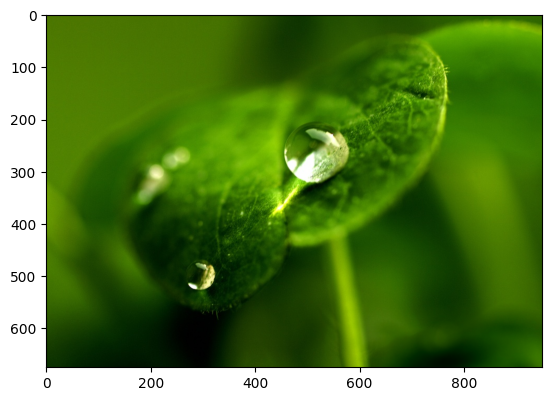

In [72]:
dew_img =cv2.cvtColor(dew_img, cv2.COLOR_BGR2RGB)
plt.imshow(dew_img)

In [85]:
import os

# Path to your main dataset directory (train, val, or test)
dataset_dir = r'D:\DATA_FOR_CV\DATA\Weather_dataset'  # change to val or test if needed

total_images = 0

# Loop through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len([
            img for img in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, img))
        ])
        print(f"{class_name}: {image_count} images")
        total_images += image_count

print(f"\nTotal images in '{dataset_dir}': {total_images}")


dew: 698 images
fogsmog: 851 images
frost: 475 images
glaze: 639 images
hail: 591 images
lightning: 377 images
rain: 526 images
rainbow: 232 images
rime: 1160 images
sandstorm: 692 images
snow: 621 images

Total images in 'D:\DATA_FOR_CV\DATA\Weather_dataset': 6862


In [88]:
total_images*0.1*0.1

68.62

### Splitting for flow directory

In [89]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set base directory
base_data_dir = r'D:\DATA_FOR_CV\DATA\Weather_dataset'
train_dir = os.path.join(base_data_dir, 'train')
val_dir = os.path.join(base_data_dir, 'val')
test_dir = os.path.join(base_data_dir, 'test')

# Create required folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class
for class_name in os.listdir(base_data_dir):
    class_path = os.path.join(base_data_dir, class_name)

    # Skip train/val/test folders or non-directories
    if not os.path.isdir(class_path) or class_name in ['train', 'val', 'test']:
        continue

    images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

    # Split: 80% train, 10% val, 10% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Create class-specific folders and copy images
    for folder, image_set in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        for img in image_set:
            shutil.copy(os.path.join(class_path, img), os.path.join(class_folder, img))

print("✅ Dataset successfully split into 80% train, 10% val, and 10% test.")




✅ Dataset successfully split into 80% train, 10% val, and 10% test.


### Augmentation

In [97]:
train_image_gen= ImageDataGenerator(
                              # normalize
                              rescale=1/255, 
                              rotation_range=30, 
                              width_shift_range=0.1, 
                              shear_range=0.9, 
                            zoom_range=0.2, 
                              horizontal_flip=True, 
                              height_shift_range=0.1)

In [98]:
train_set = train_image_gen.flow_from_directory(r'D:\DATA_FOR_CV\DATA\Weather_dataset\train')

Found 5484 images belonging to 11 classes.


In [99]:
val_image_gen= val_datagen = ImageDataGenerator(rescale=1./255)

In [100]:
val_set = val_image_gen.flow_from_directory(r'D:\DATA_FOR_CV\DATA\Weather_dataset\val')

Found 686 images belonging to 11 classes.


In [101]:
test_set = val_image_gen.flow_from_directory(r'D:\DATA_FOR_CV\DATA\Weather_dataset\test')

Found 692 images belonging to 11 classes.


### Applying the image gens and prep data for model

In [102]:

train_img_gen = train_image_gen.flow_from_directory(r'D:\DATA_FOR_CV\DATA\Weather_dataset\train',
                                              target_size = (224,224)
                                              , batch_size=16,
                                              class_mode = 'categorical')

Found 5484 images belonging to 11 classes.


In [106]:

val_image_gen = val_image_gen.flow_from_directory(r'D:\DATA_FOR_CV\DATA\Weather_dataset\val',
                                              target_size = (224,224)
                                              , batch_size=16,
                                              class_mode = 'categorical')

Found 686 images belonging to 11 classes.


In [112]:
test_image_gen = ImageDataGenerator(rescale=1./255)

test_img_gen = test_image_gen.flow_from_directory(
    r'D:\DATA_FOR_CV\DATA\Weather_dataset\test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important for consistent evaluation, especially with confusion matrix etc.
)


Found 692 images belonging to 11 classes.


### Model

In [113]:
model = Sequential()

# first conv layer
model.add(Conv2D(filters=20, kernel_size=(4,4), activation='relu', input_shape=(224,224,3)))

# second conv layer

model.add(Conv2D(filters=40, kernel_size=(4,4), activation='sigmoid'))


# third conv layer

model.add(Conv2D(filters=60, kernel_size=(6,6), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())

# dense layers ANN
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))


#output
model.add(Dense(11, activation='softmax'))

c:\Users\Zehra\anaconda3\envs\env_for_eda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [114]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 221, 221, 20)   │           980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 218, 218, 40)   │        12,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 213, 213, 60)   │        86,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 106, 106, 60)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 674160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    86,292,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,401,859 (329.60 MB)

 Trainable params: 86,401,859 (329.60 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics =['accuracy'])

In [116]:
result = model.fit(train_img_gen
                   ,epochs = 10
                   ,steps_per_epoch = 44
                    ,validation_data = val_image_gen
                 ,validation_steps =6
                 )

c:\Users\Zehra\anaconda3\envs\env_for_eda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.1089 - loss: 18.9209 - val_accuracy: 0.2083 - val_loss: 2.3872
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.1399 - loss: 2.3872 - val_accuracy: 0.1667 - val_loss: 2.3720
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.1646 - loss: 2.3710 - val_accuracy: 0.1458 - val_loss: 2.3798
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.1542 - loss: 2.3559 - val_accuracy: 0.1771 - val_loss: 2.3531
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.1661 - loss: 2.3443 - val_accuracy: 0.1562 - val_loss: 2.3601
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.1489 - loss: 2.3622 - val_accuracy: 0.1250 - val_loss: 2.3705
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.1665 - loss: 2.3357 - val_accuracy: 0.1667 - val_loss: 2.3121
Epoch 8/10
35/44 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.1197 - loss: 2.3695

c:\Users\Zehra\anaconda3\envs\env_for_eda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.1230 - loss: 2.3673 - val_accuracy: 0.1875 - val_loss: 2.3326
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.1829 - loss: 2.3238 - val_accuracy: 0.2292 - val_loss: 2.2808
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.1903 - loss: 2.3229 - val_accuracy: 0.1042 - val_loss: 2.4048
